## Conventional machine learning techniques for image dataset

This first part of the notebook aims to illustrate some of the conventional machine learning algorithms in regards to a computer vision task.

To achieve this, we are going to work with the CelebA dataset, a widely used dataset of celebrity faces. 
The goal is to predict the hair colour of the celebrity, which will be one of the following classes: black, brown, blond or gray.

The provided input are images which consists in 4d tensors. They have 3 dimensions: height, width and color depth. In particular, a certain sample comprises:

(n, 48, 48, 3)

where n indicates the number of records in that particular data batch.

The problem we are facing is **multiclass classification**. 

Our measure of success will be **total accuracy**, which will tell us how many images the model is able to correctly classify once some unseen data is avalaible.

Before moving to the next step, it is important to declare the following two hypothesis:


1.   The hair colour can be predicted given my inputs.
2.   The avalaible data is adequately informative to learn the relationship between inputs and outputs.



### Preparing the data

The following libraries will be essentials for our task. 

For convenience most of them (the basics one) will be declare in this section.

In [0]:
# Common imports
import numpy as np
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime #this enable us to timing our models
import collections
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
%matplotlib inline


The data has already been splitted into training, validation and test set. 

The idea is to build a model into the training set, evaluate it in the validation set (by tuning hyperparameters) and finally checking the performance on data that the model has never seen (test dataset).

The main goal in machine learning is to obtain models that **generalize** well, that perform well on never-before-seen data.

The following snippet is responsable for reading the data and normalize it so the values are in the range [0,1]. This is because most of the machine learning methods works better with small values as input.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

image_size = 48
hair_colours = ['black', 'blond', 'brown', 'gray']
dataset_directory = '/content/drive/My Drive/ML/' 
#training
files_train = np.load(join(dataset_directory, 'train_files.npy'))
X_train = np.load(join(dataset_directory, 'train_images.npy'))
y_train= np.load(join(dataset_directory, 'train_labels.npy'))

#validation
X_val = np.load(join(dataset_directory, 'val_images.npy'))
y_val = np.load(join(dataset_directory, 'val_labels.npy'))
files_val = np.load(join(dataset_directory, 'val_files.npy'))

#test public
X_test = np.load(join(dataset_directory, 'test_public_images.npy'))
files_test_public = np.load(join(dataset_directory, 'test_public_files.npy'))

#test private
X_test_priv = np.load(join(dataset_directory, 'test_private_images.npy'))
files_test_private = np.load(join(dataset_directory, 'test_private_files.npy'))

X_train = X_train.reshape([-1, image_size, image_size, 3]) / 255.0
X_val = X_val.reshape([-1, image_size, image_size, 3]) / 255.0
X_test = X_test.reshape([-1, image_size, image_size, 3]) / 255.0
X_test_priv = X_test_priv.reshape([-1, image_size, image_size, 3]) / 255.0

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_test_priv.shape)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
(98479, 48, 48, 3)
(12270, 48, 48, 3)
(11921, 48, 48, 3)


### Simple EDA and useful functions

A very simple exploratory data analysis (EDA) is provided. In a classic machine learning project EDA might take long time and it gives useful insights back to users.

Let's check the distribution of the hair colour in our training dataset.

Text(0, 0.5, 'Pertentages of people in the training set')

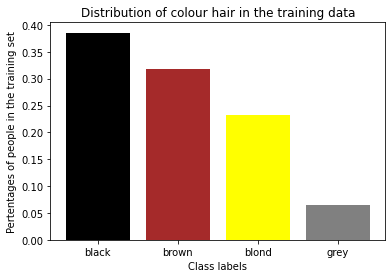

In [0]:
#Distribution of hair colour
ls=collections.Counter(labels_train)
x=['black','brown','blond','grey']
y=[ls[0]/len(labels_train),ls[2]/len(labels_train),ls[1]/len(labels_train),ls[3]/len(labels_train)]
plt.bar(x, y, color=['black', 'brown', 'yellow', 'grey'])
plt.title("Distribution of colour hair in the training data")
plt.xlabel("Class labels")
plt.ylabel("Pertentages of people in the training set")



According to the above bar chart, the majority of people in the training set has black hair, followed by brown hair.

The classes are not evenly distributed, but each class has fairly large number of individuals. Hence, data imbalance is not a relevant problem for this task.

Next, some useful functions will be declared. These will be helpful throughout the notebook.

The description of each function can be read by call the function help(function).

In [0]:
def print_csv():
    '''This function creates the csv file of the ML best model predictions for Kaggle submission'''
    final_df = pd.DataFrame({'ID':files_test_public,'Prediction': y_pred})
    final_df.to_csv(join(dataset_directory,'45539669-conv.csv'), header=True, index=False)

In [0]:
def plot_digit(data):
    '''This function is used to illustrate images (see Random Forest)'''
    image = data.reshape(48, 48,3)
    plt.imshow(image, cmap = mpl.cm.afmhot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
def train_val_accur(mod):
  '''This function plots the training and validation accuracy over the trained epochs DEEP LEARNING'''
  acc = mod.history['accuracy']
  val_acc = mod.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0.70, 0.99)
  plt.legend()

### Conventional machine learning methods

Some of the conventional machine learning techniques will be applied below.

We need to reshape our 4D tensors into 2D tensor to give as input in sklearn algorithm (only for conventional ML).

In [0]:
#predictors
X_train =np.reshape(images_train, (images_train.shape[0],6912))
X_val =np.reshape(images_val, (images_val.shape[0],6912))
X_test =np.reshape(images_test_public, (images_test_public.shape[0],6912))
#labels (just rename it for commodity)
y_train=labels_train
y_val=labels_val

Before developing any sofisticated technique a baseline model need to be built. 

We need to create models that achieve statistical power, or in other words, that do better than the baseline (dumb) model.

In [0]:
#BASELINE MODEL
import copy
train_label_copy = copy.copy(y_train)
np.random.shuffle(train_label_copy)
hits_array=np.array(y_train) == np.array(train_label_copy)
float(np.sum(hits_array)/len(y_train))


0.30794382558718103

Any models that achieve a total accuracy higher than around 0.31 can be said to achieve statistical power. If this happens, our hypothesis made above will be valid ("the output can be explained by the avalaible input") 

The goal, of course, is to create models that can do much better than that. In other words, methods that achieve high total accuracy as well as being robust.

In particular, a model is defined as robust if the total accuracy over training,validation and test set is similar.

#### Naive Bayes

**Naive Bayes** is a supervised learning classifier based on the probabilistic Bayes’ theorem.

One of the assumption here is that the predictors need to be independent to each other (which can be considered as quite strong assumption some time). 

There are different versions avalaible based on supplementary predictor assumptions.

We are trying to model a Naive Bayes classifier for multinomial models with default parameters.

In [0]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
startTime = datetime.now()
naive_clf = MultinomialNB()
naive_clf.fit(X_train, y_train)
print(datetime.now() - startTime)

0:00:02.649745


In [0]:
#Evaluation of the model on training and validation
y_pred_t,y_pred_v=naive_clf.predict(X_train),naive_clf.predict(X_val)
print("Training Acc:",round(accuracy_score(y_train, y_pred_t),4),"Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Training Acc: 0.497 Validation Acc: 0.5042


The algorithm takes less than 3 seconds to train a model, which is quite impressive. Although we achieve statistical power, the total accuracy of around 0.50 does not look good which can be explained by the wrong initial assumptions made at the begin.



#### Decision tree

A **Decision Tree** is a method that can be used to divide up a large collection of data into successively smaller sets of records by applying a sequence of simple decision rules. It makes almost no assumptions about the data.

It is usually prone to overfit, especially if left with no restriction.

Hence, it is important to apply regularization in order to restrict Decision Tree’s freedom during training.

Let's fine tune Decision Tree (**Grid Search**) in order to find the suitable hyperparameters. Although this is not done with the full dataset (limited memory capability), it gives an idea for which hyperparameters we should choose.

In addition, those values can prevent a model to overfit.

In [6]:
#Fine-tune for Decision Tree
from sklearn.tree import DecisionTreeClassifier
param_grid = [{'max_depth': [8,10,12], 'min_samples_leaf': [220, 250, 280],'max_features': [1000,2000,3000]}]
tree_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(tree_clf, param_grid, cv=3, verbose=False, n_jobs=-1)
grid_search.fit(X_train[0:20000], y_train[0:20000])
grid_search.best_params_

{'max_depth': 10, 'max_features': 3000, 'min_samples_leaf': 250}

The **Grid Search** returns these best parameters:


1.   '*max_depth*': 10 indicates the max number of levels in a decision tree

2.   '*max_features*': 3000 indicates the max number of features considered for splitting a node

3.   '*min_samples_leaf*': 250 indicates the min number of data points placed in a node before the node is split



In [0]:
#Decision tree classifier with fine tuning
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=10,min_samples_split=250,max_features= 3000)
startTime = datetime.now()
tree_clf.fit(X_train, y_train)
print(datetime.now() - startTime)

0:03:30.534929


In [0]:
#Evaluation of the model on training and validation
y_pred_t,y_pred_v=tree_clf.predict(X_train),tree_clf.predict(X_val)
print("Training Acc:",round(accuracy_score(y_train, y_pred_t),4),"Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Training Acc: 0.75 Validation Acc: 0.7186


This is definitely a good model, especially if we compare with Naive Bayes. We achieved almost 0.72 in the validation set which brings an improvement of 0.22 in terms of total accuracy in the validation set.


#### Random Forest

Decision Trees play an important role in Random forest. 

**Random forest** in a ensemble learning technique which aggregates the prediction of several Decision Trees over different random samples (bagging).

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier. Therefore, we are reusing some of the decision Tree hyperparameters found previously with GridSearch.

In [0]:
#Random forest model
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=30,max_features=3000,min_samples_leaf=250,max_depth=10)
rnd_clf.fit(X_train, y_train)

In [0]:
#Evaluation of the model on training and validation
y_pred_t,y_pred_v=rnd_clf.predict(X_train),rnd_clf.predict(X_val)
print("Training Acc:",round(accuracy_score(y_train, y_pred_t),4),"Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Training Acc: 0.7836 Validation Acc: 0.7575


The number of Decision Trees involved are 30 (*n_estimators=30*). Each of them predicts the most probable class for each sample, and Random forest aggregates the outcomes into one by using a mode (for classification task).

We are improving by 4% the performance on validation set in comparison with previous methods.

##### Feature importance

Another great quality of Random Forests is that it is relatively easy to compute the importance of each attribute in regards to the classication task.

*Scikit-Learn* calculates this score automatically for each feature after the training process, and then it scales these values so that the sum of all importances is equal to 1.

The following chart shows a plot of each pixel’s importance.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Feature importance for Random Forest classifier')

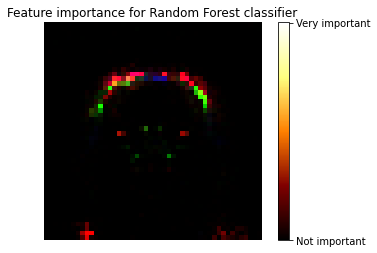

In [0]:
#FEATURE IMPORTANCE
plot_digit(rnd_clf.feature_importances_*150) #need to make larger values to see a good graph

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()*8.51])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.title("Feature importance for Random Forest classifier")


The above picture yielded some interesting results. The black colour shows those pixels that did not support the classification problem at all.

On the other hand, the coloured ones show the pixels that play an important role in the classification. We can see from the graph how these pixels form the hair shape of a typical person. In addition, by looking at the bottom left/right corner of the picture some red pixels can be found. These probably come from females which usually have longer hair than males.

Finally, these insights can be used for *feature selection* by eliminating those useless pixels.

#### Logistic Regression

Logistic Regression is one of the oldest supervised machine learning classifier. It estimates the probability that a record belongs to a particular class. It is a binary classifier per definition. 

However, there are different methods that we can use to perform multiclass classification with the support of multiple binary classifiers (See OVA or OVO). 

The following snippet of code attempts to find the best hyperparameters for logistic regression through **Grid Search**. As we have done previously, we only use a subset of the training to have a glimpse of which parameters can work best.

In [7]:
from sklearn.linear_model import LogisticRegression
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.005,0.01,0.05,0.07,0.1,0.15,0.2]}
logisticRegr = LogisticRegression()
grid_search = GridSearchCV(logisticRegr, param_grid, cv=3, verbose=False, n_jobs=-1)
grid_search.fit(X_train[0:20000], y_train[0:20000])
grid_search.best_params_


{'C': 0.07, 'penalty': 'l2'}

The Grid Search returns these best parameters:

1.   C=0.07 is the Inverse regularization parameter
2.   penalty ='l2' is the the norm used in the penalization



In [8]:
from sklearn.linear_model import LogisticRegression
startTime = datetime.now()
logisticRegr = LogisticRegression(C=0.07, penalty='l2')
logisticRegr.fit(X_train, y_train)
print(datetime.now() - startTime)

0:08:02.628277


In [0]:
#Evaluation of the model on training and validation
y_pred_t,y_pred_v=logisticRegr.predict(X_train),logisticRegr.predict(X_val)
print("Training Acc:",round(accuracy_score(y_train, y_pred_t),4),"Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Training Acc: 0.8106 Validation Acc: 0.7963


Surprisingly, logistic regression outperforms Random forest both in accuracy and speed of convergence. This is very good total accuracy (around 80% vs around 75%(RF)). 

This model achieve 82% on the public test set (Output from Kaggle).

In addition, the model is quite robust (no overfitting) since it shows similar accuracies over the training,validation and test sets.

Next, we use an ensemble learning technique to try to improve this classifier. The idea is training '*logisticRegr*' on different random subsets of the training set. 

For classification tasks, when all predictors are trained, the final prediction for an instance is simply an aggregation of the predictions of all predictors. The aggregation function is typically the statistical mode.

In [0]:
#logistic regression bagging
from sklearn.ensemble import BaggingClassifier
startTime = datetime.now()
bag_clf = BaggingClassifier(
logisticRegr, n_estimators=100,
max_samples=1000, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train[0:10000], y_train[0:10000])
print(datetime.now() - startTime)

0:50:33.313740


In [0]:
#Evaluation of the model on training and validation
y_pred_v=bag_clf.predict(X_val)
print("Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Validation Acc: 0.7612


Although the validation accuracy is good, we were not able to improve the initial logistic regression performance. One reason can be the fact that we only use a partial dataset to fit the model (memory limitation). 

With unlimited memory space, this result might have been different.

#### Voting Classifier

We have trained few classifiers that have achieved accuracy between 75% to 80% (except Naive Bayes). The candidates classifiers are : **Decision Tree**, **Random Forest**, **Logistic Regression**. 

A well known way to create a better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes (ensemble methods). 

This majority-vote classifier
is called a hard voting classifier.

This method however works best when the candidate classifiers are independent to each other. Hence, we rule out Decision Tree given the strong connection with Random forest. 

In [0]:
#VOTING CLASSIFIER
from sklearn.ensemble import VotingClassifier
#summary of the models
rnd_clf = RandomForestClassifier(n_estimators=30,max_features=3000,min_samples_leaf=220,max_depth=8)
logisticRegr = LogisticRegression(C=0.07, penalty='l2')
#voting classifier
voting_clf = VotingClassifier(
estimators=[('lr', logisticRegr), ('rf', rnd_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

In [0]:
#Evaluation of the model on training and validation
y_pred_t,y_pred_v=voting_clf.predict(X_train),voting_clf.predict(X_val)
print("Training Acc:",round(accuracy_score(y_train, y_pred_t),4),"Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Training Acc: 0.793 Validation Acc: 0.7587


The accuracy of the individual models are:

-- Random Forest 0.7575
-- Logistic Regression 0.7963

Unfortunatelly, the voting classifier did not bring any improvement in terms of the accuracy (0.7587).

#### SVM


Next, a brief explanation of a support vector machine (SVM) is given.

**SVM** uses non-linear (or linear) mapping to trasform the original training data into a higher dimention. Within the new dimention, it searches for the linear optimal separating hyperparameter.
This can be considered as a decision boundary that separates tuples of one class to the other.

Although his high accuracy, it is quite slow.

Before fitting a model, let's fine tune the hyperparameters by using Randomized Search this time.

In [0]:
#Randomized Search for SVM
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
svm_clf = SVC(gamma="auto")
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=False, cv=3)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])
rnd_search_cv.best_params_

{'C': 10.28220625183238, 'gamma': 0.0018175149134189474}

The Randomized Search returns the following hyperparameters:


1.   C= 10.28 : The regularization parameter
2.   Gamma = 0.0018 : Kernel Coefficient



In [0]:
#SVM
from sklearn.svm import SVC
startTime = datetime.now()
svm_clf = SVC(C=10.28220625183238, gamma=0.0018175149134189474)
svm_clf.fit(X_train[0:15000], y_train[0:15000])
print(datetime.now() - startTime)


0:44:04.858156


In [0]:
#Evaluation of the model on training and validation
y_pred_v=svm_clf.predict(X_val)
print("Validation Acc:",round(accuracy_score(y_val, y_pred_v),4))

Validation Acc: 0.8184


Since SVM is quite slow for the whole dataset only a subset have been used. The time complexity of the model is not linear but rather quadratic, which makes almost impossible to train a model on such a large dataset.

Despite this, SVM slightly outperforms Logistic Regression (our best second classifier)

In [0]:
y_pred=svm_clf.predict(X_test)
print_csv()

The SVM achieved the best total accuracy on the public test set so far (0.84). 

Given SVM is the best model so far, we will explore another performance measure: the confusion matrix. 

A confusion matrix is a table (4*4 for our task) used to describe the performance of a classier. Vertically we can see the predicted values, while horizontally the observed values are displayed (validation set).

The goal of a classifier is having as many as observations in the diagonal, which means that the method in question correctly classify those tuples.

In [0]:
#Since it is the best classifier let us evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
labels = np.unique(y_val)
a=confusion_matrix(y_val,y_pred_v,labels)
pd.DataFrame(a, index=labels, columns=labels)

,0,1,2,3
0,3618,28,343,18
1,40,2484,278,50
2,862,263,3339,43
3,66,141,96,601


According to the confusion matrix:


1.   The individuals with black hair(0) are correctly classified with 0.90 chance
2.  The individuals with brown hair(1) are correctly classified with 0.87 chance
3. The individuals with blond hair(2) are correctly classified with 0.74 chance
4. The individuals with grey hair(3) are correctly classified with 0.66 chance

The SVM model "suffers" on classifying individuals with grey hair. It correctly classify 601 individuals, but for example, 141 individuals with grey hair have been missclassified to have brown hair.



### Conclusion for conventional ML algoritms

We have shown some of the most successful conventional machine learning methods. Distance based methods such as *knn* have not been covered. This is because these algorithms relies on multidimentional distance between records and this may result to be too computational costly.

**The model who achieves the best accuracy on the public test set is SVM with 0.84036.** This is an incredible outcome considering that we started with a model who achieve 0.50 (Naive Bayes) and considering the fact that we only train on 15000 records which makes up only 15% of the whole dataset.

A summary of the applied methods and their performances (on validation set) have been shown:

---Naive Bayes           0.5042

-- Decision Tree         0.7186

-- Random Forest         0.7575

-- Logistic Regression   0.7963

-- Voting Classifier     0.7587

-- SVM                   0.8184

In conclusion, some comments on possible feature works are described below:

*   With better hardware capabilities, it would be interesting seeing the behaviour of SVM on the whole dataset.

*   If the above point could be achieved, a voting classifier among the best 3 methods might improve the performance of the best individual technique.

*   Feature selection might have been applied by using only those pixels that resulted to be important (See Random Forest, Feauture importance). This would have reduce the speed of the algorithm and perhaps improve classification accuracies.

*   The hypothesis made at the begin of this notebook have been satisfied. Hence, the avalaible data is adequately informative to learn the relationship between inputs and outputs.





##  Deep learning learning techniques for image dataset

In the previuos part of the notebook we have seen how SVM was the best model in terms of performance.

-- SVM Val_Accuracy 0.8184

-- SVM Public_Test_Accuracy 0.8404

This second part of the notebook aims to illustrate some of the deep learning machine learning algorithms in regards to a computer vision task. 

To achieve this, we are going to work with the CelebA dataset, a widely used dataset of celebrity faces. The goal is to predict the hair colour of the celebrity, which will be one of the following classes: black, brown, blond or gray.

The provided input are images which consists in 4d tensors. Images usually have 3 dimensions: height, width and color depth. In particular, a certain sample comprises:

(n, 48, 48, 3)

where n indicates the number of records in that particular data batch.

The problem we are facing is **multiclass classification**.

Our measure of success will be **total accuracy**, which will tell us how many images the model is able to correctly classify once some unseen data is avalaible.

Before moving to the next step, it is important to declare the following two hypothesis:

*   The hair colour can be predicted given my inputs.
*   The avalaible data is adequately informative to learn the relationship between inputs and outputs.



### Preparing the data

The following libraries will be important throughout the notebook. 

In particular, Keras will be essential for building deep learning models.

In [0]:
# Common imports
import numpy as np
import os
from os.path import join
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections
import keras
from keras import models
from keras import layers
%matplotlib inline

### Deep learning methods

Before developing any sofisticated technique, a baseline model need to be built.

We need to create models that achieve statistical power, or in other words, that do better than the baseline (dumb) model.

In [0]:
#BASELINE MODEL
import copy
train_label_copy = copy.copy(y_train)
np.random.shuffle(train_label_copy)
hits_array=np.array(y_train) == np.array(train_label_copy)
float(np.sum(hits_array)/len(y_train))

0.3055169122350958

Any models that achieve a total accuracy higher than around 0.31 can be said to achieve statistical power. If this happens, our hypothesis made above will be valid ("the output can be explained by the avalaible input")

The goal, of course, is to create models that can do much better than that. In other words, methods that achieve high total accuracy as well as being robust.

A model is defined as robust if the total accuracy over training,validation and test set is similar.

Before training Basic Neural Network, we need to further pre-process the data by reshaping it into a shape that it can pre-process.

We also need to categorically encode the labels. Keras has a built in function that take care of it.

In [5]:
from keras.utils import to_categorical
#predictors
X_train_nn =np.reshape(X_train, (X_train.shape[0],6912))
X_val_nn =np.reshape(X_val, (X_val.shape[0],6912))
X_test_nn =np.reshape(X_test, (X_test.shape[0],6912))
#labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape

(98479, 4)

#### Basic Neural Network

The first **Neural network** is the easiest setup we can create.

We are going to model a simple stack of fully connected (Dense) layers with *'relu'* as activation function. The value that we pass to each dense layer indicates the number of hidden units of the layer.

After briefly fine tuning the network, by changing the number of hidden units, the number of layers and the learning rate of the optimizer, the more accurate solution seems to be the following.

The following structure consists in 3 layers:

1.   Input layer
2.   Hidden layer
3.   Output layer

The output layer is a 4-way *softmax* layer. It will return an array of 4 probability scores for each record.
Each picture will be assigned with the class who records the highest probability.



In [0]:
#model definition
model= models.Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=(48*48*3,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

Once the model has been defined, we need to compile it.

Since it is a multiclass, single label classification the appropriate ***loss function*** is  'categorical_crossentropy'. This function measures the distance between the probability distribution outcome by the network and the true distrubution by the labels.

As we have stated in the introduction, the ***metric*** used is the total accuracy.

Finally, an **optimizer**, which is the mechanism used by the neural networks to update the weights based on the data, has been choosen as *adam*. 



In [0]:
#Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

We are now ready to train the model.

In [0]:
#Training the model
history=model.fit(X_train_nn,y_train,
        epochs = 20,
        batch_size = 64,
        verbose=False,
        validation_data = (X_val_nn,y_val) )

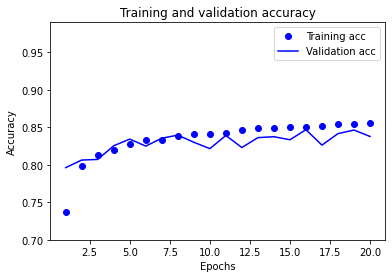

In [0]:
train_val_accur(history)

It is always important to monitor training and validation accuracy. This make sure too see the behaviour of the model over the epochs.

According to the chart above, the validation accuracy seems to reach its maximum around 19 epochs and then decay. 

Let us train a new model from scratch by using only 19 epochs.

In [0]:
#model definition
model= models.Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=(48*48*3,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))
#Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [0]:
#Training the model
history=model.fit(X_train_nn,y_train,
        epochs = 19,
        batch_size = 64,
        verbose=False,
        validation_data = (X_val_nn,y_val) )

In [0]:
results_train = model.evaluate(X_train_nn,y_train)
results_eval = model.evaluate(X_val_nn,y_val)
print("The accuracy in the training set is",results_train[1])
print("The accuracy in the validation set is",results_eval[1])


12270/12270 [==============================] - 1s 75us/step
The accuracy in the training set is 0.8538063764572144
The accuracy in the validation set is 0.8399348258972168


This new approach reaches a totally accuracy in the validation set of around 0.84 which is already a better performance comparing the best model created with conventional machine learning SVM *val_accuracy* 0.8184.

In [0]:
y_pred_proba=model.predict(X_test_nn)
y_pred=np.argmax(y_pred_proba,axis=1)
print_csv() 

Finally, the result on the public test set is 0.8450 which is very good. No regularization techniques have been applied given that the model is not overfitting.

Next, different versions of convolutional neural networks will be applied to see if we can improve this result.

#### Convolutional Neural Network (CNN)

**Convolutional Neural Networks (*CNN*)** have been really successfull in the recent years in computer vision problems.

The first *CNN* will be built from scratch. We will see later how it is possible to use a pretrained network to try improving total accuracy.

The typical structure of a CNN consists in a sequence of *Conv2D* and *Maxpooling 2D* with a simple stack of fully connected (Dense) layers at the end.

It is important to understand the sense of this structure.
The main goal is reducing the dimensionality of the images and identify local patterns related to each class.

For example, the first convolutional level contains a convolutional layer “Conv2D” and a “MaxPooling2D” layer. 

The convolutional layer uses 32, 3 by 3 pixel filters that are applied to each part of the image. The output of this layer is a 32 dimensional arrays of activation values, also known as feature maps. 

The consecutive max pooling layer downsample feature maps. The size of feature maps is halved after each max pooling2D layer.

Finally, Dense layers are attached, and a 4-way softmax layer


In [14]:
from keras import layers
from keras import models

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.30))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.15))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.15))
model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(4, activation='softmax'))
model2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)         

First attempts of this model above have shown overfitting. 

This is why, *Dropout* has been added as regularization technique. This allows a model to not overfit.

I also added a *batch normalization* layer, that guarantees activation values from the previous dense layers to have the same scale for each batch by converting them to Z-scores.

Next, we need to compile the model. A smaller *learning rate* than the default one from *Adam* (*lr* =0.001) seems like bringing higher accuracy.



In [0]:
#Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.00013)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])

In [16]:
#Training the model
history2=model2.fit(X_train,y_train,
        epochs = 20,
        batch_size = 32,
        verbose=True,
        validation_data = (X_val,y_val) )

Train on 98479 samples, validate on 12270 samples
Epoch 1/20
98479/98479 [==============================] - 28s 280us/step - loss: 0.5172 - accuracy: 0.8066 - val_loss: 0.4060 - val_accuracy: 0.8469
Epoch 2/20
98479/98479 [==============================] - 27s 273us/step - loss: 0.3454 - accuracy: 0.8729 - val_loss: 0.2938 - val_accuracy: 0.8901
Epoch 3/20
98479/98479 [==============================] - 27s 277us/step - loss: 0.3034 - accuracy: 0.8882 - val_loss: 0.2871 - val_accuracy: 0.8953
Epoch 4/20
98479/98479 [==============================] - 27s 276us/step - loss: 0.2843 - accuracy: 0.8954 - val_loss: 0.2606 - val_accuracy: 0.9042
Epoch 5/20
98479/98479 [==============================] - 27s 273us/step - loss: 0.2707 - accuracy: 0.9000 - val_loss: 0.2557 - val_accuracy: 0.9022
Epoch 6/20
98479/98479 [==============================] - 27s 278us/step - loss: 0.2573 - accuracy: 0.9047 - val_loss: 0.2496 - val_accuracy: 0.9078
Epoch 7/20
98479/98479 [==============================] 

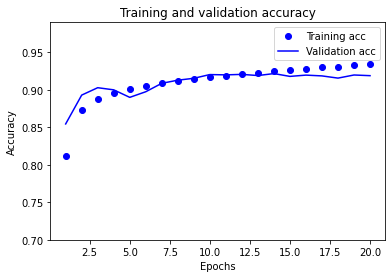

In [13]:
train_val_accur(history2)

Validation accuracy looks like increase until around 13 epochs, and then it plateaus.


In [14]:
results_train = model2.evaluate(X_train,y_train)
results_eval = model2.evaluate(X_val,y_val)
print("The accuracy in the training set is",results_train[1])
print("The accuracy in the validation set is",results_eval[1])

12270/12270 [==============================] - 1s 122us/step
The accuracy in the training set is 0.9577879309654236
The accuracy in the validation set is 0.918907880783081


We have reached almost 92% accuracy on validation set. This is a great result. This is a strong sign that CNN will outperform Basin NN in the public test set.

In [47]:
results_train = model2.evaluate(X_train,y_train)
results_eval = model2.evaluate(X_val,y_val)
print("The accuracy in the training set is",results_train[1])
print("The accuracy in the validation set is",results_eval[1])

12270/12270 [==============================] - 1s 120us/step
The accuracy in the training set is 0.9494917988777161
The accuracy in the validation set is 0.9188264012336731


In [0]:
y_pred_proba=model2.predict(X_test_priv)
y_pred=np.argmax(y_pred_proba,axis=1)
print_csv()

As expected, the totaly accuracy on the *public test set* has increased and it reached 0.92869. 

This model above reacheas an accuracy of 0.6312 on the *private test set*. 

This drop can be caused by some noise in the given private test set.

#### CNN with data augmentation

**Data augmentation** is a method that is used to artificially extend the size of a training dataset by creating transformed versions of images in the dataset.

It is very efficient especially when the avalaible dataset is small. This is not exacly our situation, however we check how it performs on a medium size dataset.

It generates more training data from existing training samples, by augmenting the images through a number of random tranformation that yield "similar" credible images.

The objective is that during the training, the model will not see the exact picure twice.

We are reusing *model2* created before from CNN from scratch.

In [0]:
#model2 has been recreated and compiled it above
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=40,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range=0.3,
      fill_mode='nearest')
batch_size=32
it=train_datagen.flow(X_train,y_train,batch_size)

Very simple transformations have been applied:

1.   *rotation_range* indicates the degree on which we rotate the picture.
2.   *height_shift_range* randomly vertical shift.
3.   *shear_range* refers to shear intensity.
4.   *zoom_range* randomly zoom inside pictures.
5.   *fill_mode* is used for filling in newly created pixels.



In [0]:
#train the model
history3=model2.fit_generator(
    it,
    steps_per_epoch= 250,
    verbose=False,
    epochs=20,
    validation_data=(X_val,y_val))
  

In [11]:
results_train = model2.evaluate(X_train,y_train)
results_eval = model2.evaluate(X_val,y_val)
print("The accuracy in the training set is",results_train[1])
print("The accuracy in the validation set is",results_eval[1])

12270/12270 [==============================] - 1s 116us/step
The accuracy in the training set is 0.8490947484970093
The accuracy in the validation set is 0.8511817455291748


The accuracy in the validation set is still high. However, data augmentation did not improve the classifier built with CNN from scatch.

#### Transfer Learning

In conclusion, **transfer learning** is applied. 
A *pre trained* network is a saved model that has been already trained on a very large dataset.

This dataset contains usually million of records and it is a multiclassification problem with hundreds of images.

We are going to use *ImageNet* and then repurpose this trained network for our hair classification task. We use VGG16 architecture (Karen Simonyan and Zisserman) developed around 2014.




In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(48, 48, 3))

According to the snippet above, we will only reuse the *convolutional base* *(Include_top = False)*.

This is because what the *convolutional base* learns is very general and therefore easily reusable. If we were used top layers, we can risk to "learn" features maps that are too specific to the Imagenet classification task.

Hence, we are going to obtain generic feature maps, such as edges.

Next we need to create our model. As we can see, on top of the convolutional base we add the densely connected layers that are specific to our problem.

In [0]:
#model definition
model4 = models.Sequential()
#convolutional base
model4.add(conv_base)
#Densely connected layers
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.25))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(4, activation='softmax'))

Before compiling the model defined above, it is necessary to freeze the convolutional base. 

This prevents not to update the convolutional base weights and therefore preserve what it has learned before.

In [0]:
#Freeze the convolutional base
conv_base.trainable = False

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.00013)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])
history4=model4.fit(X_train,y_train,
        epochs = 20,
        batch_size = 32,
        verbose=False,
        validation_data = (X_val,y_val) )

In [25]:
results_train = model4.evaluate(X_train,y_train)
results_eval = model4.evaluate(X_val,y_val)
print("The accuracy in the training set is",results_train[1])
print("The accuracy in the validation set is",results_eval[1])

12270/12270 [==============================] - 4s 288us/step
The accuracy in the training set is 0.7472862005233765
The accuracy in the validation set is 0.7278728485107422


The totally accuracy on validation drop drastically comparing previous model.

### Conclusion for deep learning methods

We can finally plot the total accuracy of the candidates model over the validation data in order to compare them graphically.

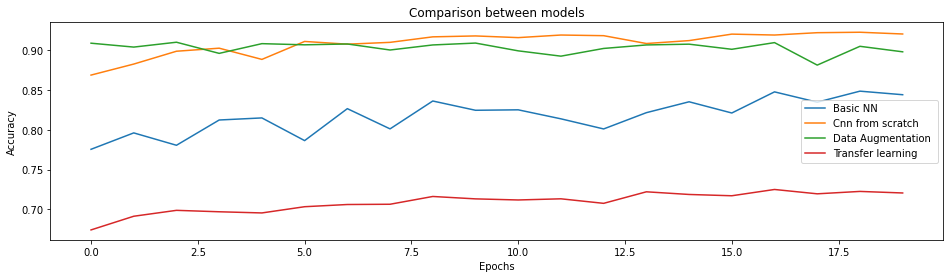

In [19]:
plt.figure(figsize=(16,4))
plt.title("Comparison between models")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["val_accuracy"],label="Basic NN")
plt.plot(history2.history["val_accuracy"],label="Cnn from scratch")
plt.plot(history3.history["val_accuracy"],label="Data Augmentation ")
plt.plot(history4.history["val_accuracy"],label="Transfer learning")
plt.legend(loc="center right")


The chart above confirms what said before. Cnn built from scratch shows better performance than the competitors.

Finally, We have shown some of the most successful deep learning methods. The hypothesis made at the begin of this notebook have been satisfied. 

Hence, the avalaible data is adequately informative to learn the relationship between inputs and outputs.

The model who achieves the best accuracy on the public test set is CNN (no data augmentation) with 0.92869.

**This has been confirmed with the private test set 0.6312**.
Once again, this unexpected drop may be caused by some noise in the new private dataset rather than lack of generalization of the model.

A summary of the applied methods and their performances (on validation set) have been shown:

---Basic Neural Network           0.839

-- Convolutional Neural Network        0.9189

-- CNN with data augmentation        0.8511

-- Transfer Learning   0.7278

## Reference

Some theory and code have been taken from the following books:


*   Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2017, by Aurélien Géron. 
*   Deep Learning With Python, by Francois Chollet, 2017
